<h1>Preparing the data</h1>
Preprocessing the dataset so that it's easy to use through the neural network.

<h2>Understanding the Dataset</h2>
Analysis on the dataset is first done to understand the generation of the dataset in the form of arrays and plots.

In [1]:
import json
import numpy as np
import os
import tensorflow as tf
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt


In [2]:
project_root = '/Users/ashwin-1994/Computer Vision/Final Project/'

In [3]:
startAll, startTrain = 0, 0


all_image_names = np.sort(os.listdir(project_root+'FreiHAND_pub_v2/training/rgb'))
with open(project_root+'FreiHAND_pub_v2/training_K.json', "r") as f:
  training_K = np.array(json.load(f))
with open(project_root+'FreiHAND_pub_v2/training_xyz.json', "r") as f:
  training_landmarks = np.array(json.load(f))

In [4]:
min_size = 1480
batch_size = 1

In [5]:
def init(startAll, startTrain, all_image_names, training_K, training_landmarks):
    all_image_names_red = all_image_names[startAll:startAll+min_size]
    training_K_red = training_K[startTrain: startTrain+min_size]
    training_landmarks_red = training_landmarks[startTrain: startTrain+min_size]
    start = 0
    end = min_size
    model_image_size = 128
    tf.keras.backend.clear_session()
    return start, end, all_image_names_red, training_K_red, training_landmarks_red, model_image_size

In [6]:
def projectPoints(point_3d, camera_matrix):
    """
    Projects 3D coordinates into image space.
    """
    point_3d = np.array(point_3d)
    camera_matrix = np.array(camera_matrix)
    point_2d = np.matmul(camera_matrix, point_3d.T).T
    return point_2d[:, :2] / point_2d[:, -1:] # Making the z coordinate 1 giving the point in 2d

In [7]:
def ConvertToHeatmaps(points,img_size=128):
  # Creating black white heatmaps from a point
  heatmaps = np.zeros((21,img_size,img_size))
  heatmaps_blurred = np.zeros((21,img_size,img_size))
  for i in range(len(points)):
    x, y = int(points[i][0] * img_size), int(points[i][1] * img_size) # Because since the images were resized, the points must be recalculated as well
    if(0<=x<img_size and 0<=y<img_size):
      heatmaps[i,y,x] = 1 # Each point will have one point heatmap with a point as white
      if heatmaps[i].max() == 1:
        heatmaps_blurred[i] = cv2.GaussianBlur(heatmaps[i], (51, 51), 3) # Blurring the nearby points in the heatmap
        heatmaps_blurred[i] = heatmaps_blurred[i] / heatmaps_blurred[i].max()
  return heatmaps_blurred

In [8]:
image = cv2.imread(project_root+'FreiHAND_pub_v2/training/rgb/00000004.jpg')

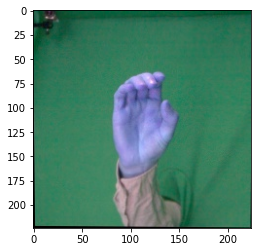

In [9]:
plt.imshow(image)
plt.show()

In [10]:
landmarks = projectPoints(training_landmarks[4],training_K[4])
for point in landmarks:
  image = cv2.circle(image, (int(point[0]),int(point[1])), 2, (0,0,255), -1)

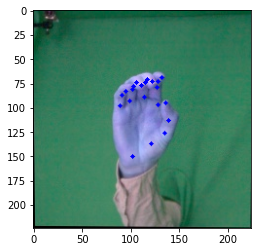

In [11]:
plt.imshow(image)
plt.show()

<h2>Dataset Preparation</h2>
Preprocessing the images and also calculating the points through the camera intrinsic matrix and 3d coordinates. The heatmaps are then calculated from those points.

In [12]:
# Calculating the keypoints and heatmaps
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def getImagesAndHeatMaps(start, end, all_image_names_red, training_K_red, training_landmarks_red, model_image_size): 
    print(str(start) + "-" + str(end))
    images_path = project_root+'FreiHAND_pub_v2/training/rgb/'
    points = np.zeros((training_landmarks_red.shape[0],training_landmarks_red.shape[1],2))
    heatmaps = np.zeros((training_landmarks_red.shape[0],model_image_size , model_image_size,21))
    images = np.zeros((training_landmarks_red.shape[0],model_image_size,model_image_size,3))
    for index in tqdm(range(start,end)):
      # Inputting images and resizing them
      img = cv2.imread(images_path + all_image_names_red[index])
      res = cv2.resize(img, dsize=(model_image_size, model_image_size), interpolation=cv2.INTER_CUBIC) # Resizing images
      images[index] = res
      images[index] = NormalizeData(images[index])
      # Calculating points and heatmaps relative to image size
      points[index] = projectPoints(training_landmarks_red[index], training_K_red[index]) / (np.array(img).shape[0]) # To get the points relative to the size of image
      heatmaps[index] = np.moveaxis(ConvertToHeatmaps(points[index]),0,2) # To get heatmaps
    return images, heatmaps

In [13]:
# Normalize images based on the channel mean and standard deviation
def normaliseImage(images):
    for i in tqdm(range(3)): # each color channel
      mean_img = np.mean(images[:,:,:,i])
      std_img = np.std(images[:,:,:,i])
      images[:,:,:,i] = (images[:,:,:,i] - mean_img) / std_img
    return images

<h2>Constructing Neural Network</h2>
Like the custom dataset created through tensorflow module. A custom neural network can be built by inheriting a class from tensorflow.

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import ReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os.path
from sklearn.model_selection import train_test_split

In [15]:
def sum_x(x):
  return tf.reduce_sum(tf.reduce_sum(x,-1),-1)

def IOUloss(y_true,y_pred):
  epsilon = 1e-6
  inter = sum_x(y_true * y_pred)
  union = (sum_x(y_true ** 2)+ sum_x(y_pred ** 2) - sum_x(y_true * y_pred))
  iou = (inter + epsilon) / (union + epsilon)
  iou = tf.reduce_mean(iou)
  return 1 - iou

In [16]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    conv = Conv2D(n_filters, 3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    conv = BatchNormalization()(conv, training=False)
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
    skip_connection = conv
    
    return next_layer, skip_connection

In [17]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)
    merge = concatenate([up, skip_layer_input], axis=3)
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [18]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3):

  inputs = Input(input_size)

  cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
  cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
  cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
  cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
  cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    

  ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
  ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
  ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
  ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)


  conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

  conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

  model = tf.keras.Model(inputs=inputs, outputs=conv10)

  return model

In [19]:
from keras import backend as K

In [20]:
# while(1):
#     print("startTrain "+ str(startTrain))
#     start, end, all_image_names_red, training_K_red, training_landmarks_red, model_image_size = init(startAll, startTrain, all_image_names, training_K, training_landmarks)
#     images, heatmaps = getImagesAndHeatMaps(start, end, all_image_names_red, training_K_red, training_landmarks_red, model_image_size)
#     images = normaliseImage(images)

#     if os.path.isdir(project_root+'models/hand_model_location_'+str(startAll)):
#         print("From load "+ str(startAll))
#         unet = tf.keras.models.load_model(project_root+'models/hand_model_location_'+str(startAll) , custom_objects={'IOUloss': IOUloss})
#     else:
#         print("New model")
#         unet = UNetCompiled(input_size=(128,128,3), n_filters=16, n_classes=21)
#         unet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate= 0.1), loss=IOUloss,  metrics=['accuracy'])
#     X_train, X_valid, y_train, y_valid = train_test_split(images, heatmaps, test_size=0.2, random_state=123)
#     steps_per_epoch = X_train.shape[0] // batch_size
#     validation_steps = y_train.shape[0] // batch_size
#     reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=6, min_lr=0.00001)
#     results = unet.fit(X_train, y_train, batch_size=batch_size, epochs=4, validation_data=(X_valid, y_valid),callbacks=[reduce_lr,])
#     startAll += min_size
#     startTrain += min_size
#     if(startTrain == 29600):
#         startTrain = 0
#         startAll = 0
#     unet.save(project_root+'models/hand_model_location_'+str(startAll))  

In [21]:
startAll, startTrain = 29600, 29600

start, end, all_image_names_red, training_K_red, training_landmarks_red, model_image_size = init(startAll, startTrain, all_image_names, training_K, training_landmarks)
images, heatmaps = getImagesAndHeatMaps(start, end, all_image_names_red, training_K_red, training_landmarks_red, model_image_size)
images = normaliseImage(images)
unet = tf.keras.models.load_model(project_root+'models/hand_model_location_0' , custom_objects={'IOUloss': IOUloss})


results = unet.evaluate(images, heatmaps, batch_size=batch_size)

0-1480


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]
2022-05-12 23:48:31.236573: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-12 23:48:31.236805: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


2022-05-12 23:49:14.317196: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-12 23:49:14.325920: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-12 23:49:14.678934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1480/1480 [==============================] - 13s 9ms/step - loss: 0.7612 - accuracy: 0.0970


<h1>Testing the data</h1>


In [22]:
def getImages(start, end, all_image_names_red, model_image_size): 
    print(str(start) + "-" + str(end))
    images_path = project_root+'FreiHAND_pub_v2/test/'
    images = np.zeros((end,model_image_size,model_image_size,3))
    for index in tqdm(range(start,end)):
      # Inputting images and resizing them
      img = cv2.imread(images_path + all_image_names_red[index])
      res = cv2.resize(img, dsize=(model_image_size, model_image_size), interpolation=cv2.INTER_CUBIC) # Resizing images
      images[index] = res
      images[index] = NormalizeData(images[index])
    return images

In [23]:
all_image_names_test = np.sort(os.listdir(project_root+'/FreiHAND_pub_v2/test/'))
start = 0
end =  9
tf.keras.backend.clear_session()


images = getImages(0, 9, all_image_names_test, model_image_size)
print(images.shape)
images = normaliseImage(images)
print(images.shape)

unet = tf.keras.models.load_model(project_root+'models/hand_model_location_0' , custom_objects={'IOUloss': IOUloss})


heatmaps = unet.predict(images)

0-9


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 15.43it/s]


(9, 128, 128, 3)


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 817.18it/s]


(9, 128, 128, 3)


2022-05-12 23:49:29.344272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [24]:
def heatmaps_to_coordinates(heatmaps):
    """
    Heatmaps is a numpy array
    Its size - (batch_size, n_keypoints, img_size, img_size)
    """
    batch_size = heatmaps.shape[0]
    sums = heatmaps.sum(axis=-1).sum(axis=-1)
    sums = np.expand_dims(sums, [2, 3])
    normalized = heatmaps / sums
    
    x_prob = normalized.sum(axis=2)
    y_prob = normalized.sum(axis=3)


    arr = np.tile(np.float32(np.arange(0, 128)), [batch_size, 21, 1])
    x = (arr * x_prob).sum(axis=2)
    y = (arr * y_prob).sum(axis=2)
    keypoints = np.stack([x, y], axis=-1)
    return keypoints / 128

In [25]:
heatmaps = np.moveaxis(heatmaps, [3], [1])

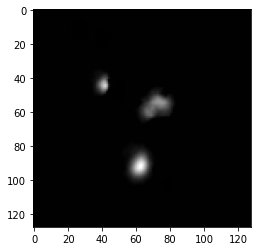

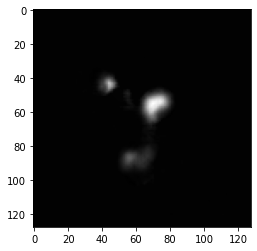

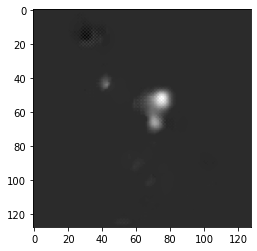

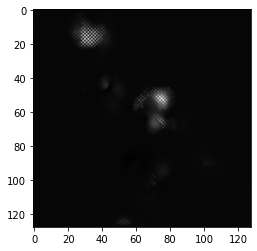

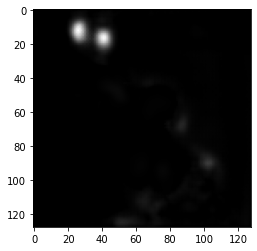

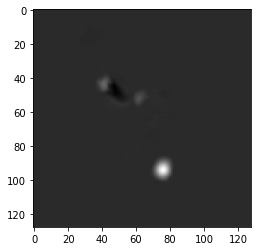

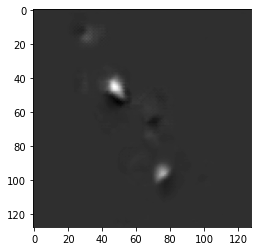

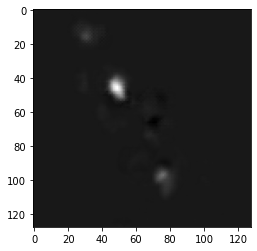

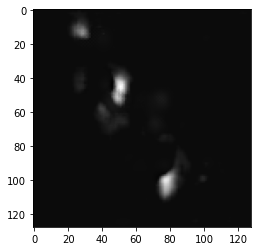

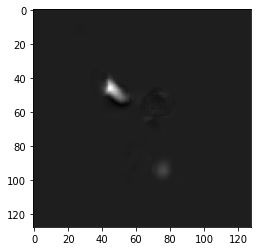

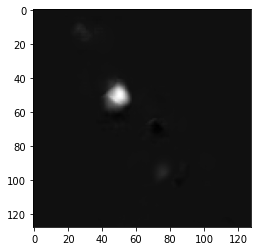

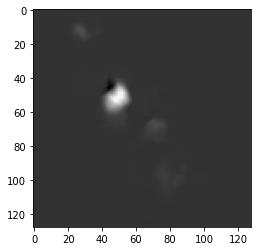

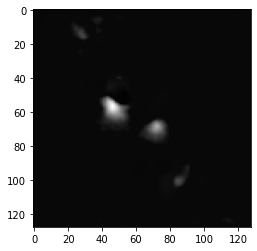

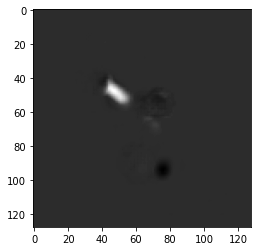

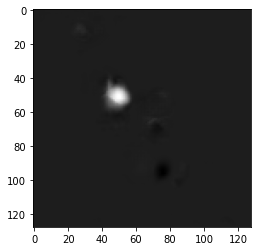

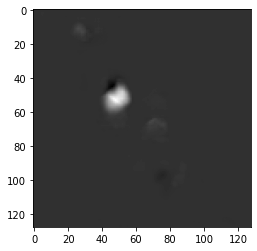

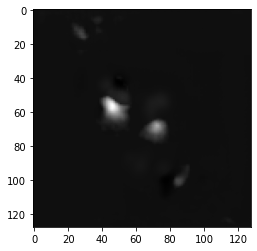

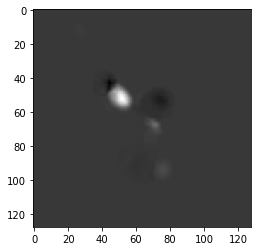

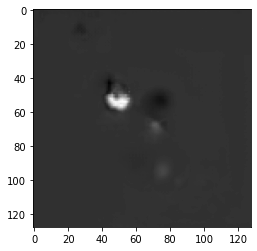

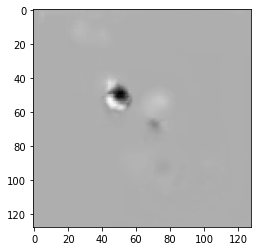

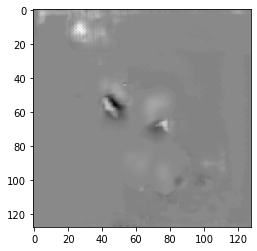

In [26]:
from matplotlib import pyplot as plt

heatmaps.shape
for i in range(0, 21):
    plt.imshow(heatmaps[6][i],cmap='gray')
    plt.show()

In [27]:
import math
points = heatmaps_to_coordinates(heatmaps)
for i in range(0, 9):   
    pred_keypoints_img = points[i]
    counter = 0

    if ((pred_keypoints_img[8][1] > pred_keypoints_img[6][1])):
        counter += 1
    if ((pred_keypoints_img[12][1] > pred_keypoints_img[10][1])):
        counter += 1
    if ((pred_keypoints_img[16][1] > pred_keypoints_img[14][1])):
        counter += 1
    if ((pred_keypoints_img[20][1] > pred_keypoints_img[18][1])):
        counter += 1
    if ((pred_keypoints_img[4][0] < pred_keypoints_img[3][0])):
        counter += 1

    print(str(counter))

1
4
3
2
4
2
3
3
3
